In [1]:
import sys,os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

base_color = sns.color_palette()[0]

Checklist:
- [x] Satisfaction vs. Salary (Better compensation)
- [x] Satisfaction vs. Language/Frameworks/Technology (Wanting new tech, Lang currently working with)
- [ ] Coeff of all categorical in relation to Satisfaction 


# StackOverflow 2020 Exploratory Data Analysis

In [2]:
df_schema = pd.read_csv("../data/processed/so_schema.csv")
df_schema.head()

,field,question_text
0,respondent,Randomized respondent ID number (not in order ...
1,main_branch,Which of the following options best describes ...
2,hobbyist,Do you code as a hobby?
3,age,What is your age (in years)? If you prefer not...
4,age1st_code,At what age did you write your first line of c...


In [3]:
df = pd.read_csv("../data/processed/so_data.csv")
df.head()

,respondent,main_branch,hobbyist,age,age1st_code,comp_freq,comp_total,converted_comp,country,currency_desc,...,survey_ease,survey_length,trans,undergrad_major,webframe_desire_next_year,webframe_worked_with,welcome_change,work_week_hrs,years_code,years_code_pro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 61 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   respondent                         64461 non-null  int64  
 1   main_branch                        64162 non-null  object 
 2   hobbyist                           64416 non-null  object 
 3   age                                45446 non-null  float64
 4   age1st_code                        57900 non-null  object 
 5   comp_freq                          40069 non-null  object 
 6   comp_total                         34826 non-null  float64
 7   converted_comp                     34756 non-null  float64
 8   country                            64072 non-null  object 
 9   currency_desc                      45472 non-null  object 
 10  currency_symbol                    45472 non-null  object 
 11  database_desire_next_year          44070 non-null  obj

## Examine Job Satisfaction

In [5]:
sat_type = CategoricalDtype(categories=["Very satisfied", "Slightly satisfied", "Neither satisfied nor dissatisfied", "Slightly dissatisfied", "Very dissatisfied"], ordered=True)
df.job_sat = df.job_sat.astype(sat_type)

df.job_sat.dtype

CategoricalDtype(categories=['Very satisfied', 'Slightly satisfied',
                  'Neither satisfied nor dissatisfied',
                  'Slightly dissatisfied', 'Very dissatisfied'],
, ordered=True)

In [6]:
df.job_sat.value_counts()

Very satisfied                        14611
Slightly satisfied                    13930
Slightly dissatisfied                  7124
Neither satisfied nor dissatisfied     5783
Very dissatisfied                      3746
Name: job_sat, dtype: int64

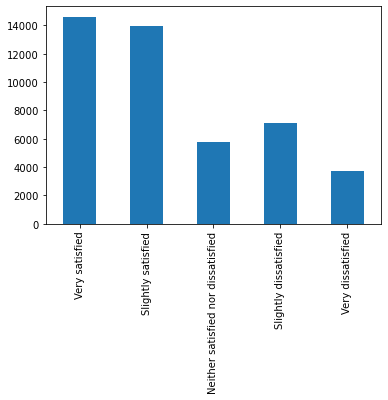

In [7]:
df.job_sat.value_counts().sort_index().plot(kind='bar');

Majority of the respondents are somewhat satisfied with their current job.

### Explore Null Job Satisfaction

In [8]:
missing_js = df.job_sat.isnull().sum()
print(f"{missing_js} missing values for Job Satisfaction")

19267 missing values for Job Satisfaction


In [9]:
df[df.job_sat.isnull()][["job_sat","dev_type", "job_factors", "job_seek", "employment"]]

,job_sat,dev_type,job_factors,job_seek,employment
2,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,Employed full-time
14,NaN,NaN,"Languages, frameworks, and other technologies ...","I’m not actively looking, but I am open to new...",Student
20,NaN,NaN,"Languages, frameworks, and other technologies ...","I’m not actively looking, but I am open to new...",Student
26,NaN,"Database administrator;Developer, full-stack;E...",NaN,NaN,Employed full-time
...,...,...,...,...,...
64456,NaN,Senior executive/VP,NaN,NaN,Employed full-time
64457,NaN,NaN,NaN,NaN,Employed full-time
64458,NaN,NaN,NaN,NaN,NaN
64459,NaN,NaN,NaN,NaN,Employed full-time


In [10]:
df.employment.value_counts()

Employed full-time                                      45270
Student                                                  7787
Independent contractor, freelancer, or self-employed     5672
Not employed, but looking for work                       2343
Employed part-time                                       2217
Not employed, and not looking for work                    322
Retired                                                   243
Name: employment, dtype: int64

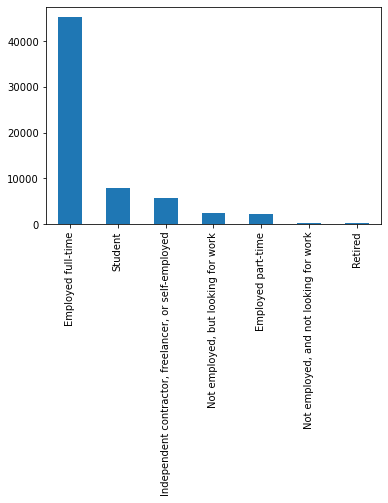

In [11]:
df.employment.value_counts().plot(kind='bar');

**Explore Null Job Satisfaction for Currently Not Employed**

In [12]:
unemployed = len(df[df.job_sat.notnull() & df.employment.isin(["Not employed, and not looking for work", "Student", "Not employed, but looking for work", "Retired"])])

print(f"{unemployed} - Number of unemployed with Job Satisfaction")

0 - Number of unemployed with Job Satisfaction


### Seeking Job Factors

**Investigate Job Seeking Status**

In [13]:
df.job_seek.value_counts()

I’m not actively looking, but I am open to new opportunities    29776
I am not interested in new job opportunities                    13001
I am actively looking for a job                                  8950
Name: job_seek, dtype: int64

In [14]:
df[["job_seek", "job_sat"]].dropna()

,job_seek,job_sat
0,I am not interested in new job opportunities,Slightly satisfied
1,I am not interested in new job opportunities,Very dissatisfied
3,"I’m not actively looking, but I am open to new...",Slightly dissatisfied
5,I am not interested in new job opportunities,Slightly satisfied
6,"I’m not actively looking, but I am open to new...",Very satisfied
...,...,...
64114,I am not interested in new job opportunities,Very satisfied
64146,I am not interested in new job opportunities,Very satisfied
64148,I am not interested in new job opportunities,Slightly satisfied
64152,"I’m not actively looking, but I am open to new...",Very satisfied


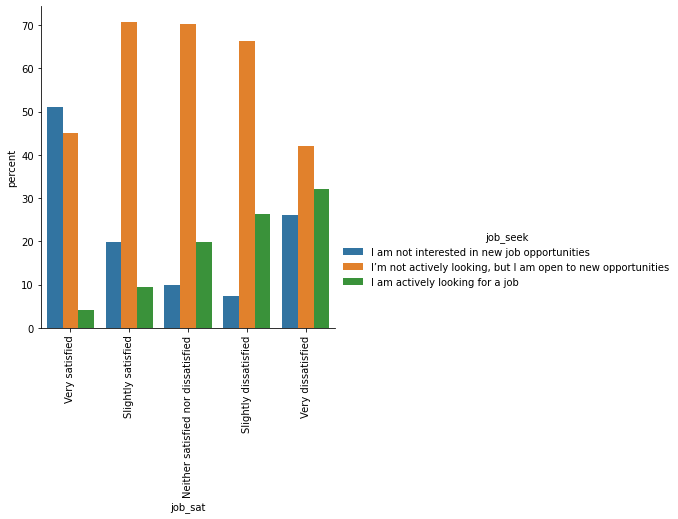

In [15]:
seek_sat = df[["job_seek", "job_sat"]].dropna()

x,y = 'job_sat', 'job_seek'

seek_g = count_percentage(x, y, seek_sat)

g = sns.catplot(x = x, y = "percent", hue = y, kind="bar", data = seek_g)
g.set_xticklabels(rotation=90);

**Check Job Factors**

In [16]:
factors = df[["employment", "job_factors"]].dropna()
factors["job_factors"] = factors.job_factors.str.split(";")
factors.head()

,employment,job_factors
0,"Independent contractor, freelancer, or self-em...","[Languages, frameworks, and other technologies..."
5,Employed full-time,"[Diversity of the company or organization, Lan..."
7,Employed full-time,"[Remote work options, Opportunities for profes..."
8,"Independent contractor, freelancer, or self-em...","[Diversity of the company or organization, Rem..."
9,Employed full-time,"[Flex time or a flexible schedule, How widely ..."


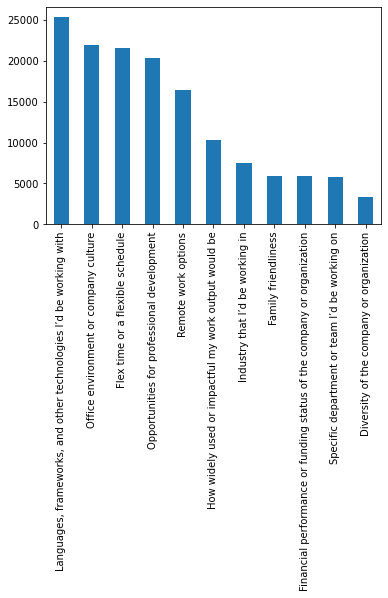

In [17]:
factors_exp = factors.explode("job_factors")
factors_exp.job_factors.value_counts().plot(kind="bar");

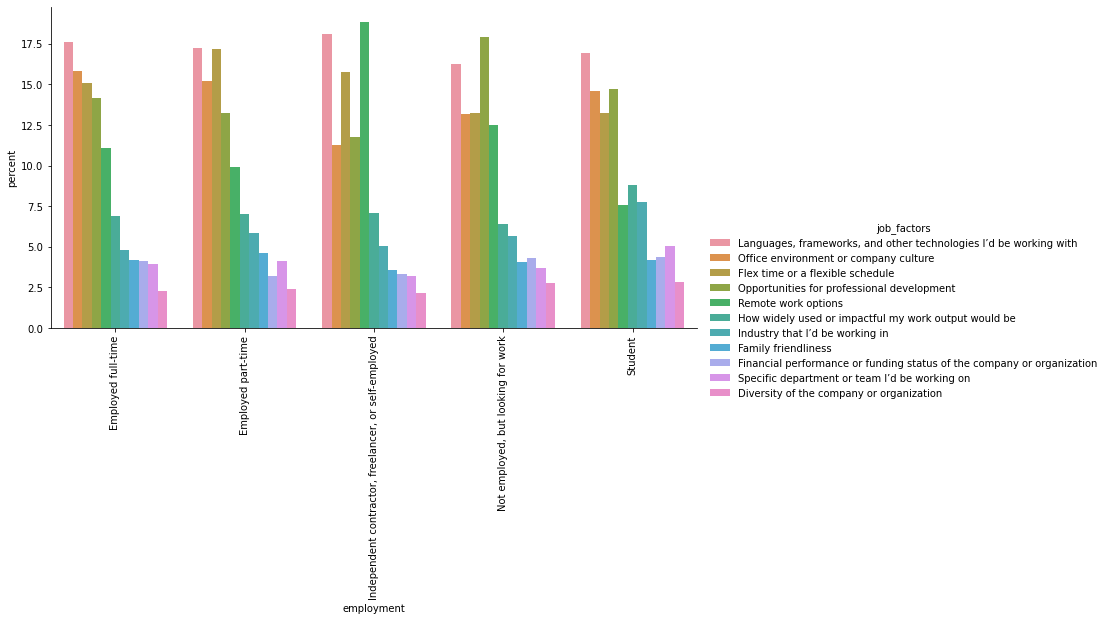

In [18]:
x,y = 'employment', 'job_factors'

factors_g = count_percentage(x, y, factors_exp)

g = sns.catplot(x = x, y = "percent", hue = y, kind="bar", aspect = 2, data = factors_g)
g.set_xticklabels(rotation=90);

**Explore New Work Driver**

In [19]:
job_hunt = df[["employment", "new_job_hunt"]].dropna()
job_hunt["new_job_hunt"] = job_hunt.new_job_hunt.str.split(";")

job_hunt.head()

,employment,new_job_hunt
6,Employed full-time,"[Better compensation, Growth or leadership opp..."
7,Employed full-time,"[Curious about other opportunities, Better com..."
8,"Independent contractor, freelancer, or self-em...","[Curious about other opportunities, Growth or ..."
9,Employed full-time,"[Curious about other opportunities, Better com..."
10,Employed full-time,"[Curious about other opportunities, Better com..."


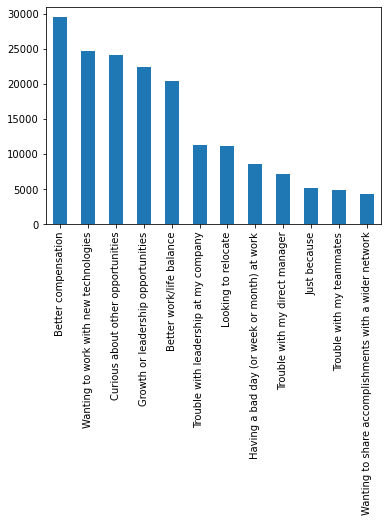

In [20]:
job_hunt_exp = job_hunt.explode("new_job_hunt")
job_hunt_exp.new_job_hunt.value_counts().plot(kind="bar");

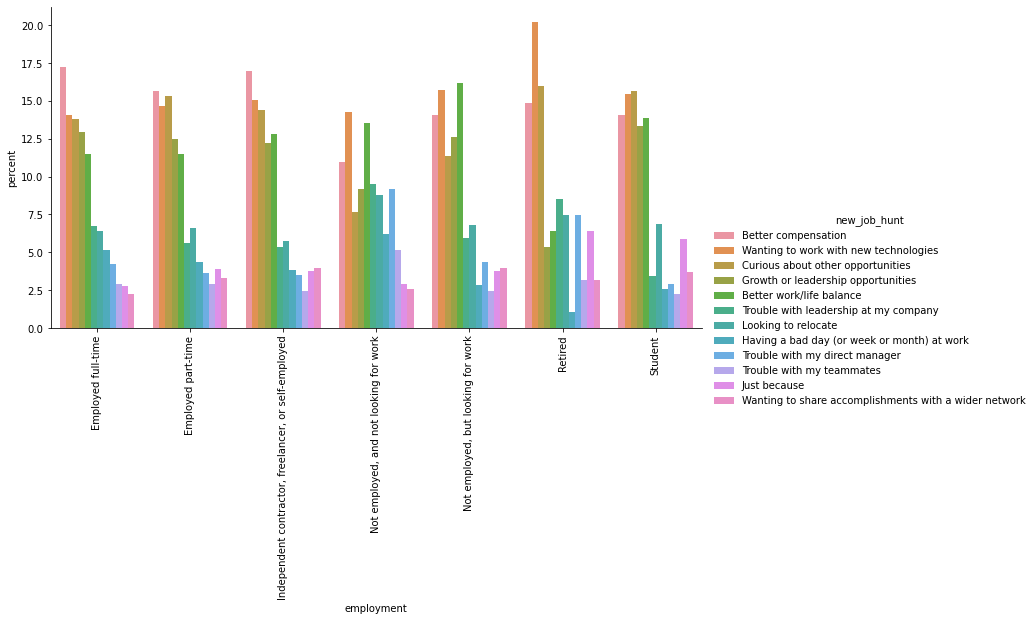

In [21]:
x,y = 'employment', 'new_job_hunt'

job_hunt_g = count_percentage(x, y, job_hunt_exp)

g = sns.catplot(x = x, y = "percent", hue = y, kind="bar", aspect = 2, data = job_hunt_g)
g.set_xticklabels(rotation=90);

**Quick Explore Job Learning Method**

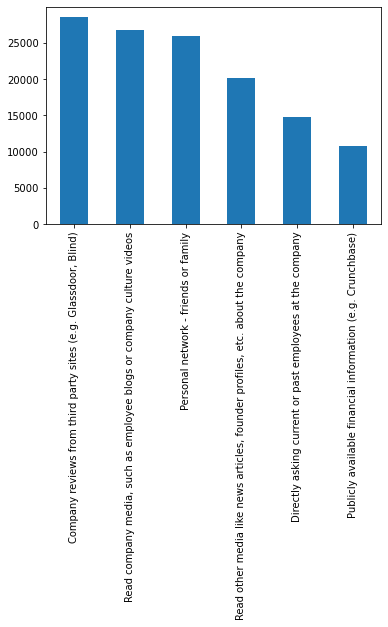

In [22]:
df.new_job_hunt_research.dropna().str.split(";").explode().value_counts().plot(kind="bar");

**Explore Salary**

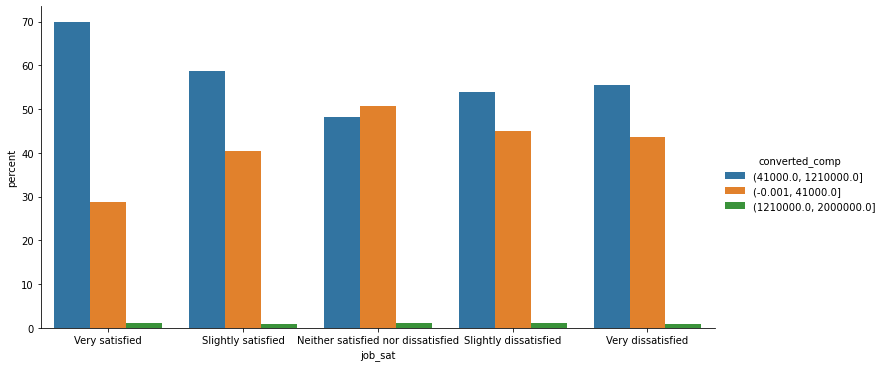

In [23]:
salary = df[["job_sat", "converted_comp"]].dropna()
salary_g = salary.groupby("job_sat")["converted_comp"].value_counts(bins=[0.0, 41000.0, 1210000.0, 2000000.0], normalize=True).mul(100).rename("percent").reset_index()

g = sns.catplot(x="job_sat", y="percent", hue="converted_comp", kind="bar", aspect=2, data=salary_g)

**Explore Languages/Frameworks/Techs**

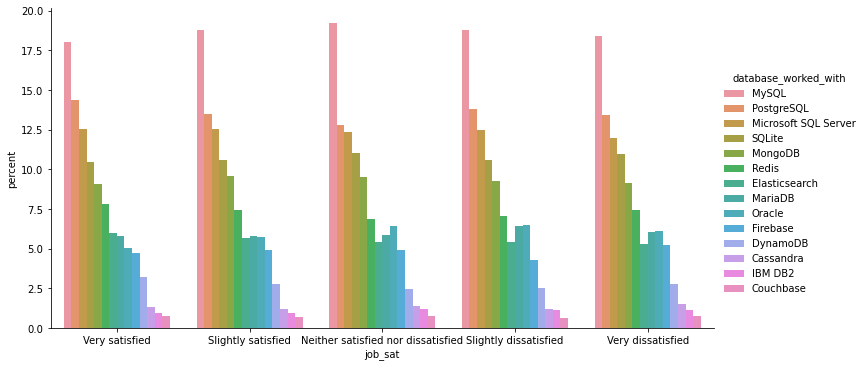

In [24]:
plot_cat("job_sat", "database_worked_with", df);

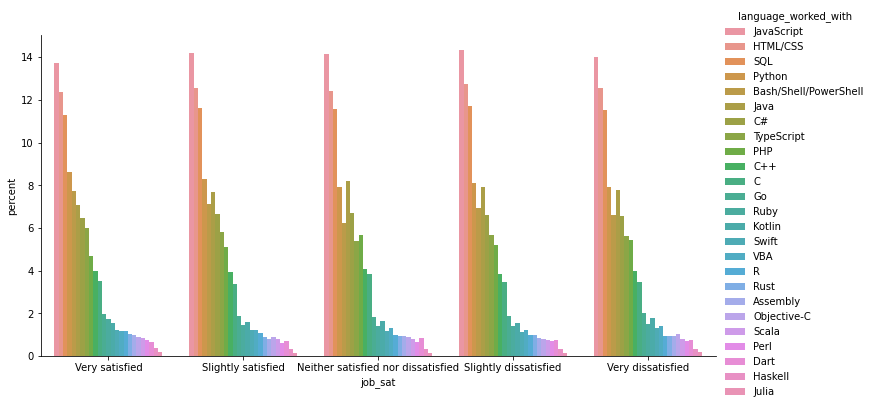

In [25]:
plot_cat("job_sat", "language_worked_with", df);

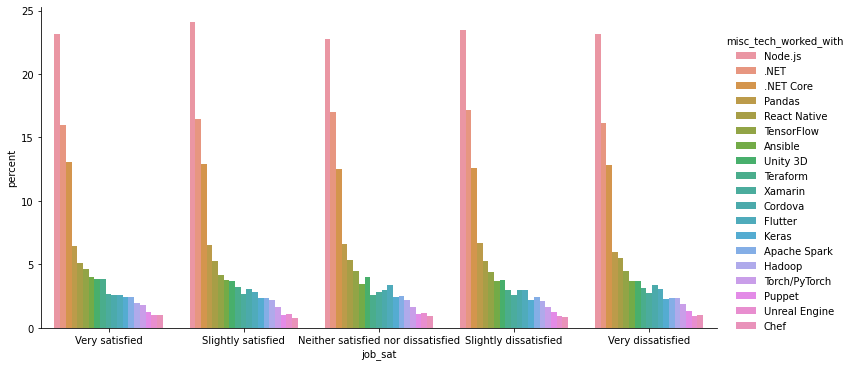

In [26]:
plot_cat("job_sat", "misc_tech_worked_with", df)

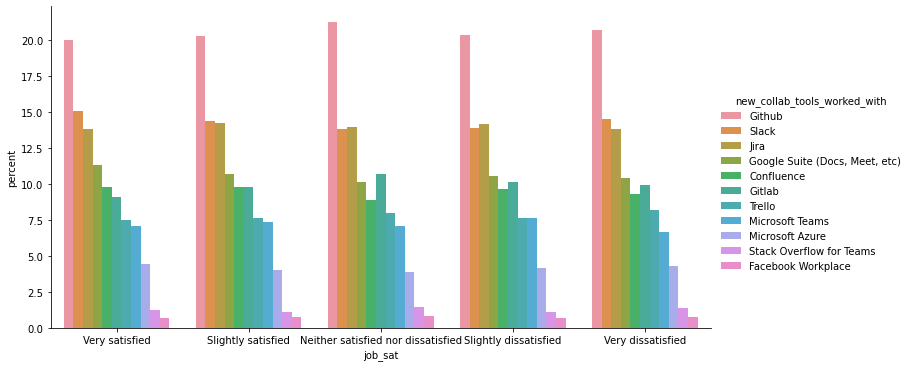

In [27]:
plot_cat("job_sat", "new_collab_tools_worked_with", df)

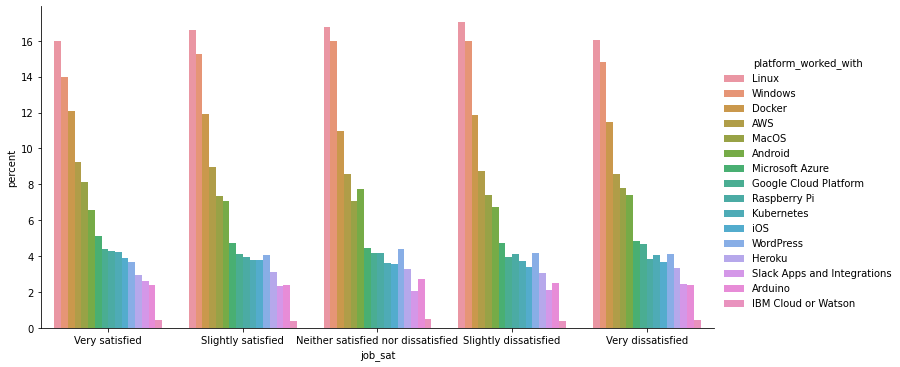

In [28]:
plot_cat("job_sat", "platform_worked_with", df)

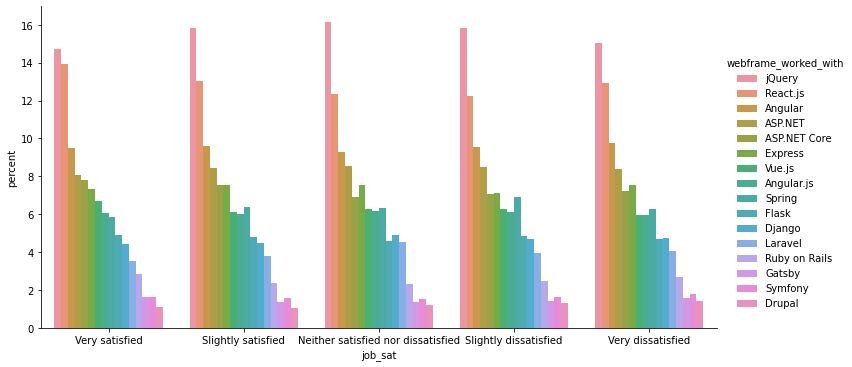

In [29]:
plot_cat("job_sat", "webframe_worked_with", df)

**Explore All Categorical**

In [30]:
X, y = clean_data(df)

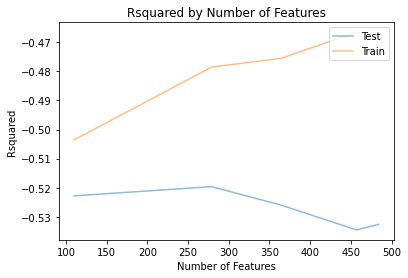

In [31]:
cutoffs = [1000, 100, 50, 30, 25]

r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_mod(X, y, cutoffs)

In [32]:
coef_df = coef_weights(lm_model.coef_[0], X_train)

coef_df.head(20)

,est_int,coefs,abs_coefs
173,new_onboard_good_Yes,0.813403,0.813403
46,country_Finland,0.602361,0.602361
34,country_Belgium,0.580067,0.580067
87,country_United States,0.572628,0.572628
81,country_Sweden,0.527928,0.527928
43,country_Denmark,0.525507,0.525507
248,years_code_Less than 1 year,-0.512480,0.512480
64,country_New Zealand,0.503502,0.503502
78,country_South Korea,0.497203,0.497203
190,purchase_what_I have little or no influence,-0.477791,0.477791
